In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345
estimator = Estimator()

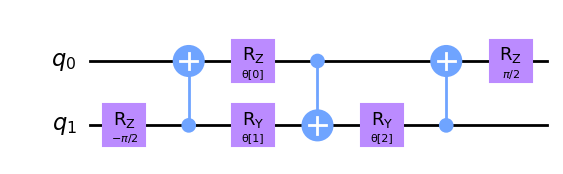

In [2]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

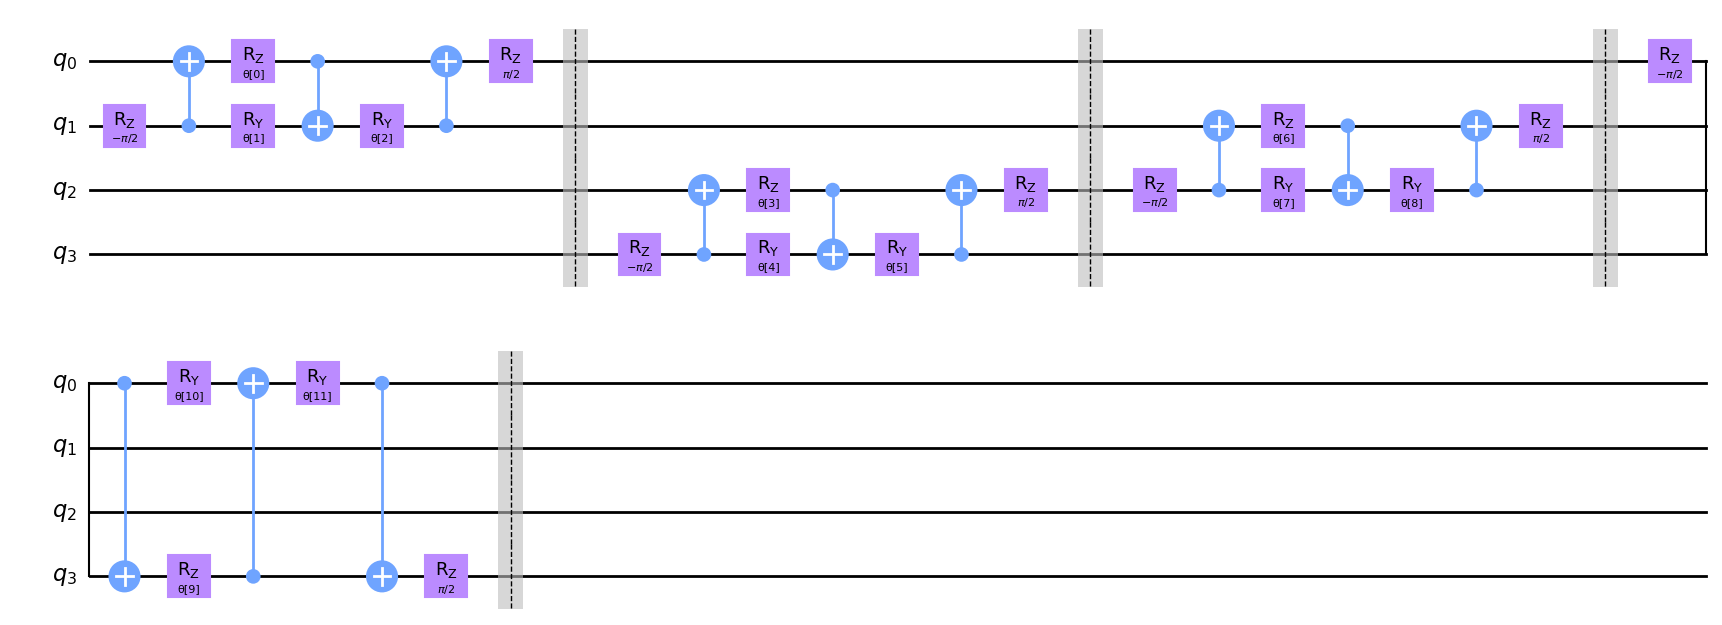

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

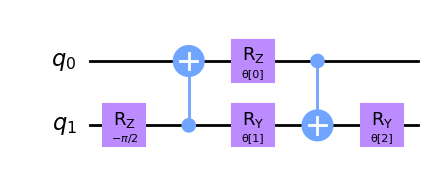

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

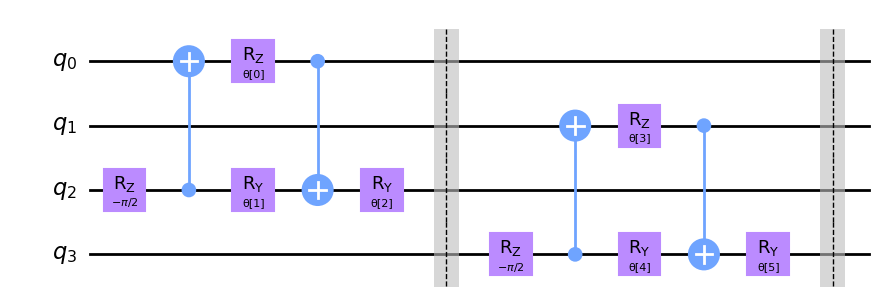

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

In [55]:
from torchvision import datasets, transforms
from torchvision.transforms import Resize

def generate_dataset(num_images):
    # Load MNIST test set
    mnist = datasets.MNIST(
        root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
    )
    # Downsample images from 28x28 to 8x8
    resize = Resize((8, 8))
    # Filter for labels 0 and 1
    idx_0 = np.where(mnist.targets == 0)[0][:num_images]
    idx_1 = np.where(mnist.targets == 1)[0][:num_images]
    idx = np.append(idx_0, idx_1)
    images = []
    labels = []
    for i in idx:
        img = mnist.data[i].numpy().astype(np.float32) / 255.0
        images.append(img)
        labels.append(int(mnist.targets[i].item()))
    return images, labels


In [56]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

ValueError: cannot reshape array of size 784 into shape (8,8)

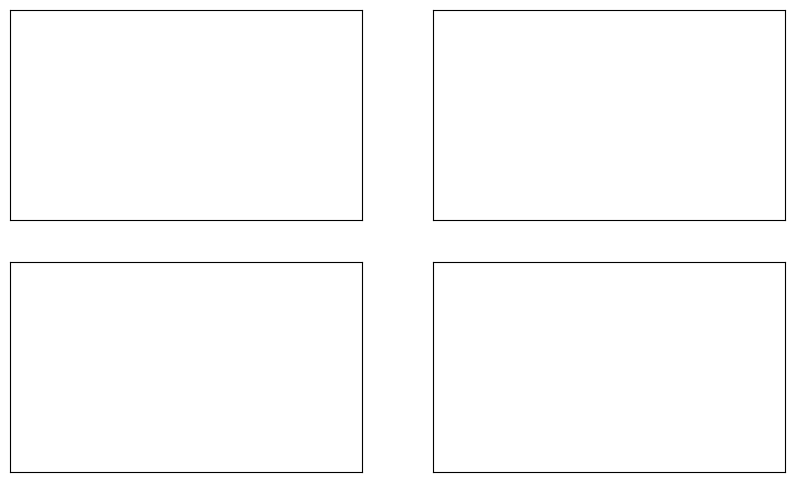

In [64]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(train_images[i].reshape(8, 8), aspect="equal")
    ax[i // 2, i % 2].set_title(f"MNIST label: {train_labels[i]}")
plt.subplots_adjust(wspace=0.1, hspace=0.025)


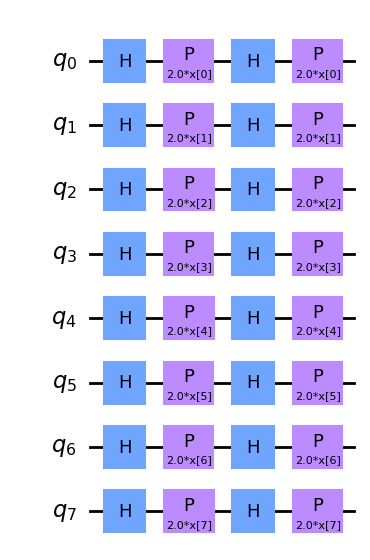

In [58]:
feature_map = ZFeatureMap(8)
feature_map.decompose().draw("mpl", style="clifford")

In [59]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


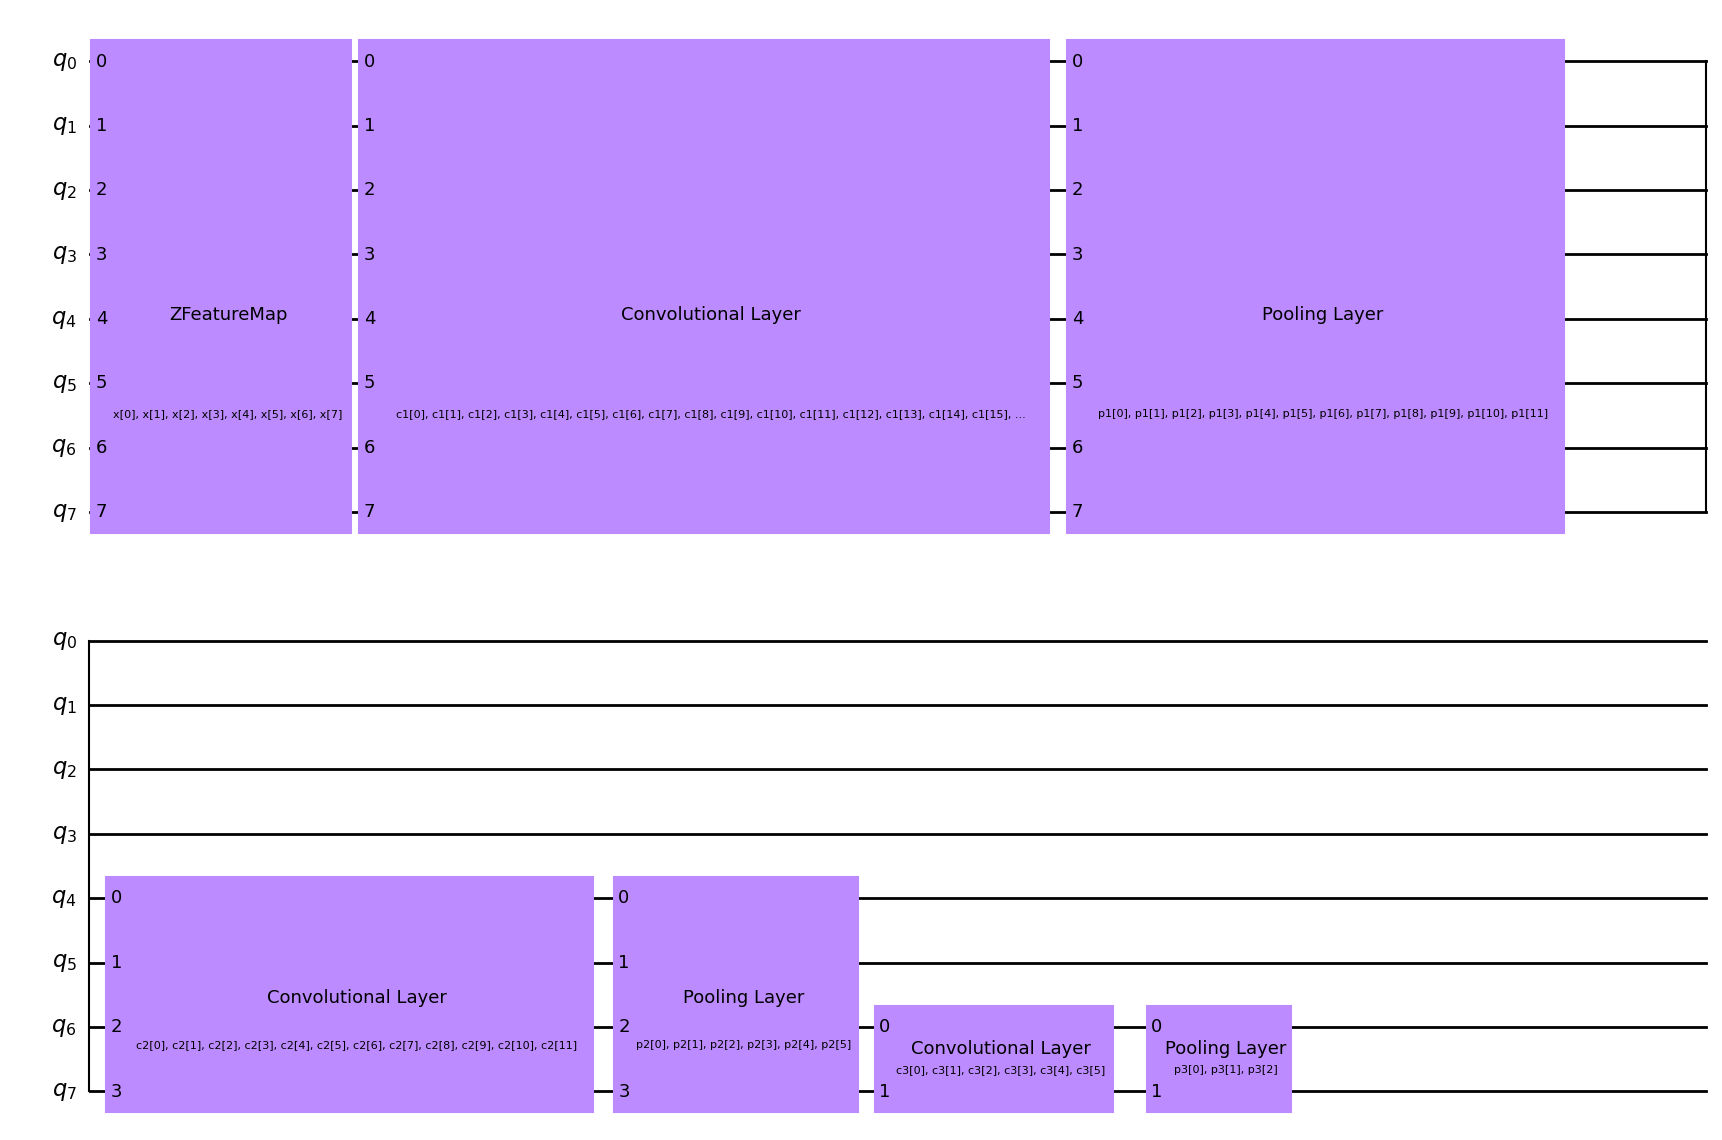

In [60]:
circuit.draw("mpl", style="clifford")

In [61]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [62]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

In [63]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

QiskitMachineLearningError: 'Input data has incorrect shape, last dimension is not equal to the number of inputs: 8, but got: 28.'

Accuracy from the test data : 86.67%


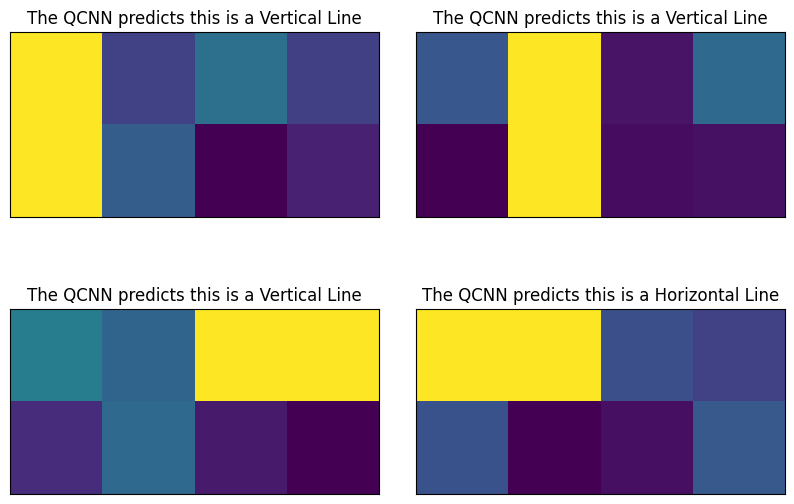

In [18]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
# Modified QCNN network so that it uses the same MNIST input and labels images 0 and 1

import torch.nn as nn
import torch.nn.functional as F
from torch import cat
from torch.nn import Conv2d, Dropout2d, Linear
from qiskit_machine_learning.connectors import TorchConnector

class QCNN(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        # Map features to a 2-dimensional vector for the quantum layer.
        self.fc2 = Linear(64, 2)  
        # TorchConnector wraps the QNN. It expects a 2-d input and produces a scalar.
        self.qnn = TorchConnector(qnn)
        # Final layer: maps the QNN's scalar output to 2 classes (0 and 1).
        self.fc3 = Linear(1, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Then create your QNN and instantiate the network as before:
qnn4 = create_qnn()  # Assuming create_qnn() remains as before.
model4 = QCNN(qnn4)